# Init

In [1]:
import logging
import os
import torch
import sympy  as sp
from   typing import Dict, List, Tuple, Callable
from   tqdm   import tqdm
from   datetime import datetime
import plotly.graph_objects as go



# Ax Imports
import nevergrad as ng

# Symxplorer Specific Imports
from   symxplorer.symbolic_solver.domains        import ExperimentResult

from   symxplorer.designer_tools.symbolic_sizing import Symbolic_Sizing_Assist
from   symxplorer.designer_tools.utils           import weighted_mse_loss, plot_ac_response, plot_complex_response, get_bode_fitness_loss, Transfer_Func_Helper
from   symxplorer.designer_tools.tf_models       import First_Order_LP_TF, Second_Order_LP_TF, cascade_tf
from   symxplorer.designer_tools.visualizer      import Symbolic_Visualizer, Bode_Visualizer

s = sp.symbols("s")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dtype  = torch.double

torch.set_default_dtype(dtype)
torch.set_default_device(device)
print(f'Using device: {device} and dtype: {dtype}')

2025-02-10 15:06:02,886 - matplotlib - matplotlib data path: /Users/danialnoorizadeh/.pyenv/versions/myenv/lib/python3.12/site-packages/matplotlib/mpl-data
2025-02-10 15:06:02,890 - matplotlib - CONFIGDIR=/Users/danialnoorizadeh/.matplotlib
2025-02-10 15:06:02,920 - matplotlib - interactive is False
2025-02-10 15:06:02,920 - matplotlib - platform is darwin
2025-02-10 15:06:02,952 - matplotlib - CACHEDIR=/Users/danialnoorizadeh/.matplotlib
2025-02-10 15:06:02,956 - matplotlib.font_manager - Using fontManager instance from /Users/danialnoorizadeh/.matplotlib/fontlist-v390.json


Using device: cpu and dtype: torch.float64


In [2]:
path_to_pkl = "Runs/results.pkl"
symbolic_experiment_result = ExperimentResult("Sizing Stage")
symbolic_experiment_result = symbolic_experiment_result.load(path_to_pkl)

# Class Definition

In [3]:
class Nevergrad_Symbolic_Bode_Fitter:
    def __init__(self, 
                 tf_to_size: sp.Expr,
                 target_tf: sp.Expr,
                 c_range: List[float] = [1e-12, 1e-9], 
                 r_range: List[float] = [1e2, 1e5],
                 frequencies: torch.Tensor = torch.logspace(3, 8, 1000),
                 freq_weights: torch.Tensor = None,
                 max_loss: float = 20,
                 loss_norm_method: str = "min-max",
                 loss_type:     str = "mse",
                 optimizer_name: str = "CMA",
                 random_seed: int = 42,
                 verbose_logging: bool = True
                 ):
        

        self.sizing_assist = Symbolic_Sizing_Assist(tf=tf_to_size)
        self.target_tf = target_tf
        self.c_range = c_range
        self.r_range = r_range
        self.frequencies = frequencies
        self.freq_weights = freq_weights if freq_weights is not None else torch.ones_like(frequencies)
        self.max_mse_loss = max_loss
        self.mse_norm_method  = loss_norm_method
        self.loss_type = loss_type
        self.optimizer_name = optimizer_name
        self.random_seed  = random_seed
        self.verbose_logging = verbose_logging
        
        self.parametrization: ng.p.Dict = None
        self.cap_denormailization: float  = None
        self.res_denormailization: float  = None
        self.helper_functions = Transfer_Func_Helper()
        self.optimizer: ng.optimization.base.Optimizer = None
        self.optimizer_trace: List[Tuple[ng.p.Dict, float]] = []
        self.global_min_index: int = 0 # the index of the global min

        self._default_var_bounds = [1, 100]

    def parameterize(self, log_scale: bool = True) -> Tuple[Dict, List, List]:
    
        self.cap_denormailization = min(self.c_range)
        self.res_denormailization = min(self.r_range) 

        c_range_normalized = [1, max(self.c_range)/min(self.c_range)]
        r_range_normalized = [1, max(self.r_range)/min(self.r_range)]

        parameters: Dict[str, ng.p.Log] = {}
        for var in self.sizing_assist.design_variables_dict:
            param = None
            if var.startswith("R"):
                parameters[str(var)] = ng.p.Log(lower=r_range_normalized[0], upper=r_range_normalized[1]) if log_scale else ng.p.Scalar(lower=r_range_normalized[0], upper=r_range_normalized[1]) 
            elif var.startswith("C"):
                parameters[str(var)] = ng.p.Log(lower=c_range_normalized[0], upper=c_range_normalized[1]) if log_scale else ng.p.Scalar(lower=c_range_normalized[0], upper=c_range_normalized[1]) 
            else:
                parameters[str(var)] = ng.p.Log(lower=self._default_var_bounds[0], upper=self._default_var_bounds[1]) if log_scale else ng.p.Scalar(lower=self._default_var_bounds[0], upper=self._default_var_bounds[1])  # Default bounds (fail gracefully)

        self.parametrization = ng.p.Dict(**parameters)
        
        return parameters, self.cap_denormailization, self.res_denormailization

    def denormalize_params(self, parameterization: Dict[str, float]) -> Dict[str, float]:

        for key in parameterization.keys():
            if "R_" in key:
                parameterization[key] = parameterization[key] * self.res_denormailization
            elif "C_" in key:
                parameterization[key] = parameterization[key] * self.cap_denormailization

        return parameterization

    def eval_symbolic_tf_fit(self, parameterization: Dict[str, float], epsilon: float = 1e-10) -> Tuple[Dict, torch.Tensor]:
        
        curr_tf_symbolic = self.sizing_assist.sub_val_design_vars(parameterization)

        current_complex_response = self.helper_functions.eval_tf(tf=curr_tf_symbolic, f_val=self.frequencies)
        target_complex_response  = self.helper_functions.eval_tf(tf=self.target_tf, f_val=self.frequencies)

        fit_summary = get_bode_fitness_loss(current_complex_response=current_complex_response, target_complex_response=target_complex_response, freq_weights=self.freq_weights, loss_type=self.loss_type)
        
        mag_loss   = fit_summary['mag_loss']
        phase_loss = fit_summary['phase_loss']

        # Add new data to the summary
        fit_summary["current_complex_response"] = current_complex_response
        fit_summary['target_complex_response']  = target_complex_response
        fit_summary["mag-phase-target"]    = self.helper_functions.get_mag_phase_from_complex_response(complex_response_array=target_complex_response, epsilon=epsilon)
        fit_summary["mag-phase-optimized"] = self.helper_functions.get_mag_phase_from_complex_response(complex_response_array=current_complex_response, epsilon=epsilon)
        fit_summary["frequencies"] = self.frequencies       

        return fit_summary, mag_loss, phase_loss
    
    def evaluate(self, parameterization: Dict[str, float], include_phase_loss: bool = True, include_mag_loss: bool = True, penality_mult: float = 1, epsilon: float = 1e-10) -> float:

        parameterization  = self.denormalize_params(parameterization)
        
        fit_summary, mag_loss, phase_loss = self.eval_symbolic_tf_fit(parameterization, epsilon=epsilon)
        # l1norm = torch.sum(torch.tensor([val for val in parameterization.values()]))

        loss = 0
        loss += mag_loss   if include_mag_loss else 0
        loss += phase_loss if include_phase_loss else 0
        loss  = torch.clip(loss, min=0, max=self.max_mse_loss)

        # Add penalty for violating mag
        loss += penality_mult * max(0, fit_summary['target_max_mag'] - fit_summary['curr_max_mag'])**2

        # Log the summary if an improvement happens


        return float(loss.detach())

    def create_experiment(self, budget: int, overwrite_optimizer:ng.optimization.base.Optimizer = None) -> bool:
        if self.parametrization is None:
            print("NEED TO CALL self.parameterize")
            return False

        elif overwrite_optimizer is not None:
            self.optimizer = overwrite_optimizer(parametrization=self.parametrization, budget=budget)
        else:
            self.optimizer = ng.optimizers.registry.get(self.optimizer_name)(parametrization=self.parametrization, budget=budget)
        print(f"Optimizer is set to {self.optimizer.name} with budget = {budget}")
        return True
    
    def optimize(self, include_mag_loss: bool = True, include_phase_loss: bool = True, epsilon: float = 1e-10, render_optimization_trace: bool = True, verbose_logging: bool = True) -> bool:

        if self.optimizer is None:
            return False
        
        
        # Track the loss for plotting
        loss_values = []
        trials = []

        self.optimizer_trace = []  # Store the optimization trace
        
        # Run the optimization process
        for trial in tqdm(range(self.optimizer.budget), desc="Optimizing", unit="trial"):
            candidate = self.optimizer.ask()  # Get a new candidate
            loss = self.evaluate(candidate.value, include_mag_loss=include_mag_loss, include_phase_loss=include_phase_loss, epsilon=epsilon)  # Evaluate function
            self.optimizer.tell(candidate, loss)  # Provide feedback to optimizer
            self.optimizer_trace.append((candidate, loss))  # Log the achieved loss
            
            # Store loss and step number for plotting
            loss_values.append(loss)
            trials.append(trial)

            if loss < self.optimizer_trace[self.global_min_index][1]:
                self.global_min_index = trial
        
        # Plot the loss as a function of optimization step
        self._plot_loss(trials, loss_values)

        return True
    
    def get_best(self) -> Dict[str, float]:

        if self.optimizer is None:
            print("Need to set the optimizer by calling self.create_experiment")
            return
        
        if len(self.optimizer_trace) < 1:
            print("need to run self.optimize")
            return
        
        best_solution, loss = self.optimizer_trace[self.global_min_index]
        best_parameters = best_solution.value

        print("Optimized x - normalized:", best_solution.value)
        print("Optimized x - de-normalized:", self.denormalize_params(best_solution.value))

        print("loss:", loss)

        return self.denormalize_params(best_solution.value), loss
    
    def _plot_loss(self, trials, loss_values):
        """Plot the loss as a function of optimization steps with Plotly."""
        fig = go.Figure()
        
        # Add a line plot with trials on the x-axis and loss_values on the y-axis
        fig.add_trace(go.Scatter(x=trials, y=loss_values, mode='markers+lines', name='Loss', line=dict(color='blue', width=2)))

        # Add title and labels
        fig.update_layout(
            title='Loss vs. Optimization Trial',
            xaxis_title='Optimization Step',
            yaxis_title='Loss',
            template='plotly_dark',  # Optional: Use dark theme for the plot
            showlegend=True
        )
        
        # Show the interactive plot
        fig.show()

    def plot_solution(self, prameterization: Dict[str, float]):

        fit_summary, mag_loss, phase_loss = self.eval_symbolic_tf_fit(prameterization)
        print(f"mag_loss {mag_loss}, phase_loss {phase_loss}, max-mag {fit_summary['curr_max_mag']}")

        target_complex_response  = fit_summary['target_complex_response']
        current_complex_response = fit_summary['current_complex_response']
        frequencies = fit_summary['frequencies']

        plot_complex_response(frequencies=frequencies, complex_response_list=[target_complex_response, current_complex_response], labels=['Target', 'Optimized'])
            

# Problem Setup

In [4]:
selected_filters = symbolic_experiment_result.get_filter_types("X-INVALID-ORDER")
len(selected_filters)

3190

In [5]:
idx = 2365 # 2365 is the ID of our case study

z_key = selected_filters[idx].zCombo
tf_to_size = selected_filters[idx].transferFunc
tf_to_size

R_1*R_2*R_6/(C_1*C_4*C_6*R_1*R_2*R_3*R_5*R_6*s**3 + R_1*R_5 - R_2*R_3 + R_2*R_5 + R_3*R_5 + s**2*(C_1*C_4*R_1*R_2*R_3*R_5 - C_1*C_6*R_1*R_2*R_3*R_6 + C_1*C_6*R_1*R_2*R_5*R_6 + C_1*C_6*R_1*R_3*R_5*R_6 + C_4*C_6*R_2*R_3*R_5*R_6) + s*(-C_1*R_1*R_2*R_3 + C_1*R_1*R_2*R_5 + C_1*R_1*R_3*R_5 + C_4*R_2*R_3*R_5 + C_6*R_1*R_5*R_6 - C_6*R_2*R_3*R_6 + C_6*R_2*R_5*R_6 + C_6*R_3*R_5*R_6))

In [6]:
frequencies = torch.logspace(5, 10, 20000)

# Butterworth Filter (3rd order)
fc = 1e7
tf1 = Second_Order_LP_TF(q=1, fc=1.272*fc, dc_gain=1e3)
tf2 = First_Order_LP_TF(fc=1*fc, dc_gain=1)

target_tf = cascade_tf(list_of_tfs=[tf1, tf2], dc_gain_multiplier=1)
target_tf

1000.0/((5.0e-8*s/pi + 1)*(1.54513270835806e-15*s**2/pi**2 + 3.93081761006289e-8*s/pi + 1))

Calculating Phases: 100%|██████████| 200/200 [00:01<00:00, 195.61it/s]


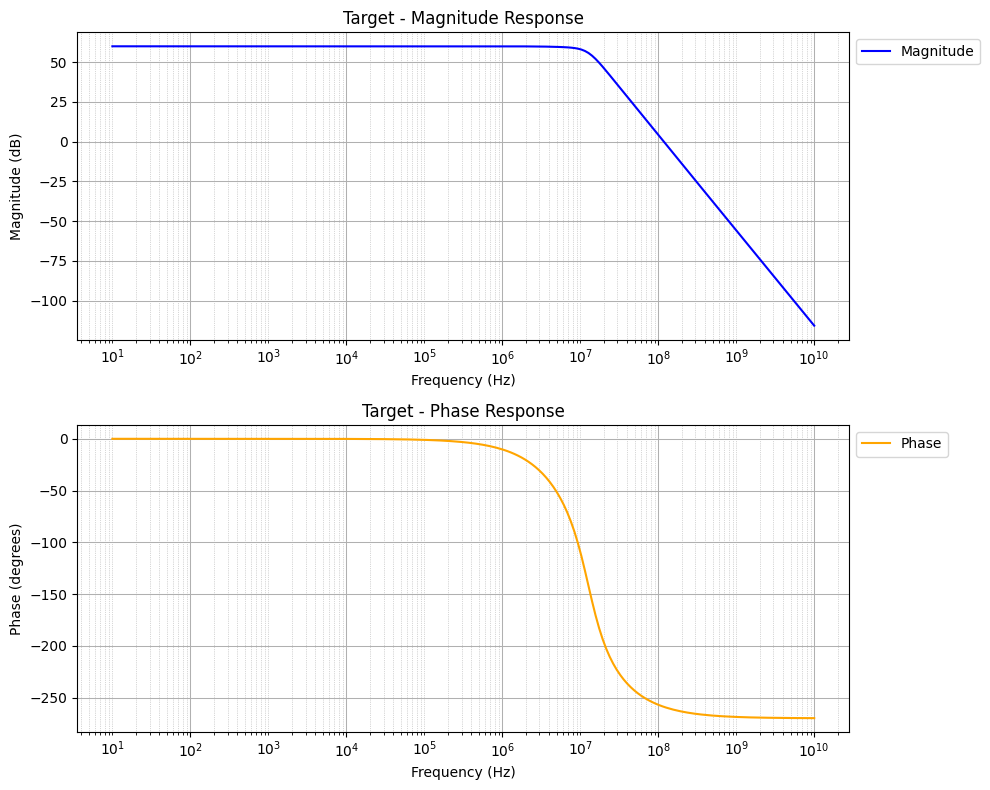

In [7]:
from symxplorer.designer_tools.visualizer import Symbolic_Visualizer

vis = Symbolic_Visualizer(tf=target_tf)
vis.visualize(start_freq_order=1, end_freq_order=10, num_of_points=200, title="Target")

In [8]:
# Define range
lower_bound = 1e6
upper_bound = 12e6

# Generate binary mask
weighted_frequencies = torch.where((frequencies >= lower_bound) & (frequencies <= upper_bound), 1, 1)

# Optimizer

In [27]:
ng_wrapper = Nevergrad_Symbolic_Bode_Fitter(
    tf_to_size=tf_to_size,
    target_tf=target_tf,
    c_range=[1e-12, 1e-9],
    r_range=[1e2, 1e5],
    frequencies=frequencies,
    # freq_weights=weighted_frequencies,
    max_loss=float('inf'),
    loss_norm_method='min-max',
    loss_type="mse",
    optimizer_name="LogBFGSCMAPlus",
    random_seed=42
)

Computing filter parameters for BiQuad:   0%|          | 0/1 [00:00<?, ?filter/s]


In [28]:
ng_wrapper.parameterize(log_scale=False)

({'R_5': Scalar{Cl(1,1000,b)}[sigma=Scalar{exp=2.03}]:500.5,
  'C_4': Scalar{Cl(1,1000.0000000000001,b)}[sigma=Scalar{exp=2.03}]:500.50000000000006,
  'R_3': Scalar{Cl(1,1000,b)}[sigma=Scalar{exp=2.03}]:500.5,
  'R_2': Scalar{Cl(1,1000,b)}[sigma=Scalar{exp=2.03}]:500.5,
  'C_1': Scalar{Cl(1,1000.0000000000001,b)}[sigma=Scalar{exp=2.03}]:500.50000000000006,
  'C_6': Scalar{Cl(1,1000.0000000000001,b)}[sigma=Scalar{exp=2.03}]:500.50000000000006,
  'R_6': Scalar{Cl(1,1000,b)}[sigma=Scalar{exp=2.03}]:500.5,
  'R_1': Scalar{Cl(1,1000,b)}[sigma=Scalar{exp=2.03}]:500.5},
 1e-12,
 100.0)

In [29]:
ng_wrapper.create_experiment(budget=5000)
ng_wrapper.optimize(include_mag_loss=False, include_phase_loss=True, render_optimization_trace=True)

Optimizer is set to LogBFGSCMAPlus with budget = 5000


Optimizing: 100%|██████████| 5000/5000 [03:19<00:00, 25.08trial/s]


True

In [35]:
best_params, loss = ng_wrapper.get_best()
best_params, loss

Optimized x - normalized: {'R_5': 222.94284468124616, 'C_4': 13.345160575641112, 'R_3': 9.676445711840225, 'R_2': 115.52237446542875, 'C_1': 1.110691595124603, 'C_6': 1.0107580596915196, 'R_6': 272.66115457558493, 'R_1': 214.7347744673893}
Optimized x - de-normalized: {'R_5': 22294.284468124617, 'C_4': 1.3345160575641112e-11, 'R_3': 967.6445711840225, 'R_2': 11552.237446542875, 'C_1': 1.110691595124603e-12, 'C_6': 1.0107580596915196e-12, 'R_6': 27266.11545755849, 'R_1': 21473.47744673893}
loss: 1.7977041981975002


({'R_5': 22294.284468124617,
  'C_4': 1.3345160575641112e-11,
  'R_3': 967.6445711840225,
  'R_2': 11552.237446542875,
  'C_1': 1.110691595124603e-12,
  'C_6': 1.0107580596915196e-12,
  'R_6': 27266.11545755849,
  'R_1': 21473.47744673893},
 1.7977041981975002)

In [36]:
ng_wrapper.plot_solution(best_params)

mag_loss 0.2023306413127928, phase_loss 1.7977041981975002, max-mag 79.13992309570312


## Plot

In [32]:
# best_params, loss = ng_wrapper.optimizer_trace[4200]
# best_params = ng_wrapper.denormalize_params(best_params.value)
# best_params, loss

In [33]:
ng_wrapper.plot_solution(best_params)

mag_loss 0.2023306413127928, phase_loss 1.7977041981975002, max-mag 79.13992309570312


In [34]:
ng_wrapper.

SyntaxError: invalid syntax (3862376741.py, line 1)

In [ ]:
get_bode_fitness_loss()

# Testing

In [ ]:
import sympy as sp
import nevergrad as ng

# Step 1: Define symbolic expression
R1, R2, C1, C2 = sp.symbols("R1 R2 C1 C2")  # Example circuit elements
expr = (R1 + R2) / (C1 * C2 * R2)  # Example transfer function
free_vars = list(expr.free_symbols)

# Step 2: Define bounds
resistor_bounds = (1, 1e6)  # Example: 1Ω to 1MΩ
capacitor_bounds = (1, 1e1)  # Example: 1pF to 1µF

# Step 3: Define the parameterization dynamically
parametrization = ng.p.Dict(
    **{
        str(var): ng.p.Scalar(lower=resistor_bounds[0], upper=resistor_bounds[1])
        if str(var).startswith("R")  # Check if it's a resistor
        else ng.p.Scalar(lower=capacitor_bounds[0], upper=capacitor_bounds[1])  # Otherwise, capacitor
        for var in free_vars
    }
)

# Step 4: Define the objective function
def objective_function(params):
    subs_dict = {var: params[str(var)] for var in free_vars}  # Extract values correctly
    evaluated_value = expr.subs(subs_dict).evalf()
    target_value = 10  # Example target
    return abs(evaluated_value - target_value)  # Minimize error

# Step 5: Optimize
optimizer_name = ng.optimizers.CMA(parametrization, budget=1000)
recommendation = optimizer_name.minimize(objective_function)

# Step 6: Output best parameters
print("Optimized parameters:", recommendation.value)


In [ ]:
parametrization.value

In [ ]:
import nevergrad as ng
import numpy as np

# Define an optimization problem (minimize f(x) = (x - 2)^2)
def objective_function(params):
    x = params["x"]
    return (x - 2) ** 2  # Goal: x should be close to 2

# Define the search space
parametrization = ng.p.Dict(x=ng.p.Scalar(lower=-1, upper=1))

# Create an optimizer
optimizer_name = ng.optimizers.CMA(parametrization, budget=500)

# Use ask-and-tell framework
for _ in range(500):  # Run optimization loop
    candidate = optimizer_name.ask()  # Get a new candidate
    loss = objective_function(candidate.value)  # Evaluate function
    optimizer_name.tell(candidate, loss)  # Provide feedback to optimizer

# Get final recommendation
best_solution = optimizer_name.provide_recommendation()
print("Optimized x:", best_solution.value)


In [ ]:
ng.optimizers.registry.get("CMA")